## Explore how a vegetation index is calculated: effect of thresholding

We take as example one image (example RGB image from `drone2report`) and with one vegetation index, **GLI** in this illustration.

We start by import libraries: we are using the `imageio` *Python* library for input/output of image data (tiff raster images in this illustration):

In [31]:
import imageio.v2 as imageio
import matplotlib.pyplot as plt

In [32]:
fname = '../../paper-drone2report/data/example_RGB/ROI_id=1.png'
pic = imageio.imread(fname)

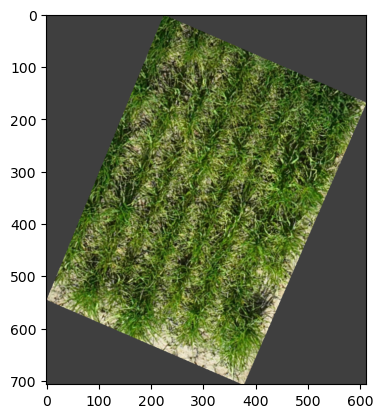

In [33]:
plt.figure()
plt.imshow(pic)

In [34]:
print('Type of the image : ' , type(pic))
print()
print('Shape of the image : {}'.format(pic.shape))
print('Image Hight {}'.format(pic.shape[0]))
print('Image Width {}'.format(pic.shape[1]))
print('Dimension of Image {}'.format(pic.ndim))

Type of the image :  <class 'numpy.ndarray'>

Shape of the image : (707, 612, 3)
Image Hight 707
Image Width 612
Dimension of Image 3


The input image has the characteristics detailed above, e.g. 3 channels and size 707 x 612 (height, width): **total number of input pixels is 432,684**

In [ ]:
plt.title('R channel')
plt.ylabel('Height {}'.format(pic.shape[0]))
plt.xlabel('Width {}'.format(pic.shape[1]))

plt.imshow(pic[ : , : , 0])

In [ ]:
plt.title('R channel')
plt.ylabel('Height {}'.format(pic.shape[0]))
plt.xlabel('Width {}'.format(pic.shape[1]))

plt.imshow(pic[ : , : , 1])
#plt.show()

In [ ]:
plt.title('R channel')
plt.ylabel('Height {}'.format(pic.shape[0]))
plt.xlabel('Width {}'.format(pic.shape[1]))

plt.imshow(pic[ : , : , 2])
plt.show()

In [ ]:
pic[ : , : , 2]

In [ ]:
pic = imageio.imread(fname)

pic[0:720 , : , 0] = 255 # full intensity to those pixel's R channel
plt.figure()
plt.imshow(pic)
plt.show()


In [ ]:
import numpy as np
import numpy.ma as ma

In [ ]:
pic = imageio.imread(fname)

fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))

for c, ax in zip(range(3), ax):
    
    # create zero matrix
    split_img = np.zeros(pic.shape, dtype="uint8") # 'dtype' by default: 'numpy.float64'
    
    # assing each channel 
    split_img[ :, :, c] = pic[ :, :, c]
    
    # display each channel
    ax.imshow(split_img)

In [ ]:
pic[0:10, 0:10, 0]

In [ ]:
def GLI(img, channels):
	"""Green leaf index, uses red, green, blue"""
	try:
		red   = img[:,:,channels.index('red')]
		green = img[:,:,channels.index('green')]
		blue  = img[:,:,channels.index('blue')]
	except ValueError:
		#if this clause is activated it means that the requested channel(s) are not available
		return np.nan
	#if we get here the index can be applied to the current image
	return(
		(2.0*green - red - blue) / 
		(2.0*green + red + blue)
	) 

In [ ]:
channels = ['red','green','blue']
channels.index('red')

In [ ]:
red   = pic[:,:,channels.index('red')]
green = pic[:,:,channels.index('green')]
blue  = pic[:,:,channels.index('blue')]

In [ ]:
red

In [ ]:
(2.0*green - red - blue) / (2.0*green + red + blue)

In [ ]:
gli_values = GLI(pic, channels)
gli_values

In [ ]:
gli_values[120:180,220:280]

In [ ]:
np.mean(gli_values)

## masked arrays

We first try masking unnecessary values of the index (the triangular margins outside of the ROI).
We do this by **masking index values calculated on out-of-shape pixels**.

This is a quick-n-dirty initial attempt.
A better way would be to mask directly the grey pixels in the input RGB image data (TODO)

In [ ]:
mask_0 = gli_values == 0

In [ ]:
masked_gli = ma.masked_array(gli_values, mask_0)

In [ ]:
masked_gli

#### N. of masked pixels

In [ ]:
np.ma.sum(mask_0)

#### N. of total pixels in the index matrix

Why fewer than the n. of pixels in the original image?

In [ ]:
mask_0.shape[0] * mask_0.shape[1]

#### Average GLI value on single plot calculated after masking

Masking was based on GLI values (0s were masked):

In [ ]:
np.ma.mean(masked_gli)

### Masking directly the input data


In [ ]:
pic = imageio.imread(fname)

In [ ]:
mask_0 = (pic[:,:,0] & pic[:,:,1] & pic[:,:,2] == 63)

In [ ]:
mask_0